# LibRecommenders

### Installing libraries

In [1]:
!pip install LibRecommender

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from libreco.data import random_split, DatasetPure
from libreco.algorithms import LightGCN  # pure data, algorithm LightGCN
from libreco.evaluation import evaluate

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\user\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Preparing dataset

In [3]:
products = pd.read_csv('../data/product_details.tsv', sep='\t')
users = pd.read_csv('../data/user_game_time.tsv', sep='\t')

In [4]:
data = users.merge(products, left_on='game_id', right_on='id', how='right')
data = data[['user_id', 'id', 'genre_1_id', 'game_time']].fillna(0)
data = data.rename(columns={'user_id': 'user', 'id': 'item', 'genre_1_id': 'label', 'game_time': 'time'})

In [5]:
data

,user,item,label,time
0,0.0,1215594767,60,0.0
1,0.0,1443160656,61,0.0
2,0.0,1584656762,61,0.0
3,0.0,1181317918,61,0.0
4,0.0,1240322197,60,0.0
...,...,...,...,...
1005,0.0,1245136314,56,0.0
1006,0.0,2053196692,60,0.0
1007,0.0,1558393671,87,0.0
1008,0.0,1584302429,56,0.0


### Splitting data into train and test datasets

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.33)

In [7]:
len(train), len(test)

(676, 334)

In [8]:
train_data, data_info = DatasetPure.build_trainset(train)
test_data = DatasetPure.build_testset(test)

### Building the model

In [9]:
lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=16,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cpu",
)

### Training

In [10]:
lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
)


Training start time: 2024-03-17 17:07:30


train: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Epoch 1 elapsed: 0.021s
	 train_loss: 0.693


train: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Epoch 2 elapsed: 0.019s
	 train_loss: 0.6928


train: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Epoch 3 elapsed: 0.013s
	 train_loss: 0.6927


### Evaluating

In [11]:
evaluate(
    model=lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
)

eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.26it/s]


{'loss': 0.6929891713218086,
 'roc_auc': 0.4985298863351142,
 'precision': 0.0,
 'recall': 0.0,
 'ndcg': 0.0}

## Running experiments

In [12]:

lrs = np.linspace(0.001, 0.1, 100)
num_epochs = np.linspace(1, 10, 10)


losses = np.zeros((len(num_epochs), len(lrs)))
for i, epochs in enumerate(num_epochs):
    for j, lr in enumerate(lrs):
        lightgcn = LightGCN(
            task="ranking",
            data_info=data_info,
            loss_type="bpr",
            embed_size=16,
            n_epochs=int(epochs),
            lr=lr,
            batch_size=2048,
            num_neg=1,
            device="cpu",
        )


        lightgcn.fit(
            train_data,
            neg_sampling=True,
            verbose=0,
            metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
        )

        evaluation = evaluate(
            model=lightgcn,
            data=test_data,
            neg_sampling=True,
            metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
        )
        losses[i, j] = evaluation['loss']
        
row, col = np.unravel_index(losses.argmin(), losses.shape)
print(f'Best configuration:\n\tloss: {losses[row, col]}\n\tepochs: {num_epochs[row]}\n\tlr: {lrs[col]}')

Training start time: 2024-03-17 17:07:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:31



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.07it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:31



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 469.58it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 953.03it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.47it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.90it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.78it/s]


Training start time: 2024-03-17 17:07:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.78it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.39it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.49it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.68it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.05it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.88it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:33



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.38it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:33



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.79it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 641.72it/s]


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:34



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.79it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 442.81it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.61it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:34



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.23it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:34



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.08it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:34



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:34



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.14it/s]


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:35



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:35

eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:35



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.91it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:07:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.84it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:36



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.13it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1842.03it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 962.00it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:36



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:36



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:37



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:37



eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.07it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:37



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:37



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 585.47it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.67it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:38



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:39



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:39



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.66it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:39



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.12it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:40



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.14it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.90it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.49it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:40



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:40



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:41



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:41



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:41



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:41



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.16it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.58it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 949.37it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1864.14it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:42


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 962.22it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.29it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.30it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.25it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 650.99it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:43



eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 248.86it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.15it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:43


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:44



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.95it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:44


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.80it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:45



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:45



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:45


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:46



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.32it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.03it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 467.33it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 875.64it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:46



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:46


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:47



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.93it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:47


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:48



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 595.44it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.82it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:48


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.17it/s]

Training start time: 2024-03-17 17:07:48



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.10it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:49



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:49

eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:49



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:49


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.92it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.57it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.11it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.24it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.59it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:50


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]

Training start time: 2024-03-17 17:07:50



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:51



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:51



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:51



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.04it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:51


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

Training start time: 2024-03-17 17:07:52



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:52



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:52



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:52



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.81it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.56it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:52


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 941.06it/s]

Training start time: 2024-03-17 17:07:53



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1905.64it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.80it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.37it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.14it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.30it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.11it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.72it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:53



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.73it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:53


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.78it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.61it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:54

eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.48it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.49it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:54



eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Training start time: 2024-03-17 17:07:54


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 573.62it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.01it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:55



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:55



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.76it/s]

Training start time: 2024-03-17 17:07:55



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:55


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.07it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:56



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:56



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:56


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:57



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.98it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:57


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:57



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:58

eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:58



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:58


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 938.53it/s]

Training start time: 2024-03-17 17:07:59



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.92it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:07:59



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.46it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.83it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:07:59


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:00



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:00



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.17it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:00



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:00



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:00


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.56it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 936.65it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:01


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.07it/s]


Training start time: 2024-03-17 17:08:02


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:03



eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.65it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 960.67it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.18it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.91it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.98it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 986.20it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:03


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.92it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:03



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 328.76it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.59it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.19it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.87it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.87it/s]

Training start time: 2024-03-17 17:08:04



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:04



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:04


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 248.52it/s]

Training start time: 2024-03-17 17:08:05



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.74it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.03it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:05



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:05



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.93it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:05



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:05



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:05


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:06



eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:06



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:06



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:06



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:06


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1869.95it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.01it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.60it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:07


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:08


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:09



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:09



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.68it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:09


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:10



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.46it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:10



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

Training start time: 2024-03-17 17:08:10



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:10


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.64it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:11



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:11


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:12



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.95it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.08it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.39it/s]


Training start time: 2024-03-17 17:08:12


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:13



eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 284.46it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.10it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 630.15it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 949.37it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.72it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:13


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:14



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.87it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:14



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 282.83it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.43it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.27it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:14


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1959.96it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 947.44it/s]


Training start time: 2024-03-17 17:08:15


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.69it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.51it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:16



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.72it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:16


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.93it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:17



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.82it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 713.44it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 915.59it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:17


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:18



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:18


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:18



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]

Training start time: 2024-03-17 17:08:19



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:19


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:19



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 941.06it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:20



eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.20it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.81it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:20



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:20


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:21


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.41it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1971.93it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.03it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.89it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 488.96it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.49it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.16it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.85it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:22


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 133.09it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 117.06it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 661.35it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 278.82it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.57it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:23


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:23



eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 662.71it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 974.06it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:24



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:24


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.90it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:25



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:25


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 379.44it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 397.53it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.93it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:26



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:26


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:26



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:27



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:27


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.25it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.61it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:28


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:29


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.51it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.94it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.43it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.37it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:30


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.91it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:31


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:32



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:32



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.59it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.19it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:32


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.77it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:33



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:33


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 588.01it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


Training start time: 2024-03-17 17:08:34


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:35



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:35


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:35



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.77it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 464.49it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training start time: 2024-03-17 17:08:36


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:37



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:37



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:37


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Training start time: 2024-03-17 17:08:38



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:38


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.97it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.35it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.40it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 398.58it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.57it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 330.81it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.30it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.09it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.36it/s]


Training start time: 2024-03-17 17:08:39


eval_pointwise:   0%|                                                                            | 0/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.94it/s]

Training start time: 2024-03-17 17:08:40



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]

Training start time: 2024-03-17 17:08:40



eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:40


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.65it/s]


Training start time: 2024-03-17 17:08:41


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.21it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.76it/s]


Training start time: 2024-03-17 17:08:41


eval_pointwise: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.02it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.14it/s]


Training start time: 2024-03-17 17:08:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39


eval_listwise: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Training start time: 2024-03-17 17:08:41


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Detect 337 unknown interaction(s), position: [0, 2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 77, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 141, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 39

eval_listwise: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.83it/s]

Best configuration:
	loss: 0.6923017379872453
	epochs: 7.0
	lr: 0.011


### Presenting Results of Experiments

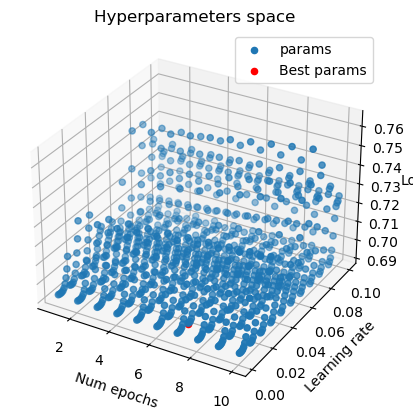

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

vepochs, vlr = np.meshgrid(num_epochs, lrs)

ax.scatter(vepochs, vlr, losses, label='params') 
ax.scatter(num_epochs[row], lrs[col], losses[row, col], c='r', label='Best params') 
ax.set_title('Hyperparameters space')
ax.set_xlabel('Num epochs')
ax.set_ylabel('Learning rate')
ax.set_zlabel('Loss')
ax.legend()

In [14]:
lightgcn.recommend_user(user=1077, n_rec=7)

Detect unknown user: 1077


{1077: array([1542088686, 1357323278, 1542088686, 1452863689, 1268302405,
        1313754214, 1207660183], dtype=int64)}

### Applying best hyperparameters

In [15]:
best_epochs, best_lr = num_epochs[row], lrs[col]

In [16]:
from typing import List, Tuple

lightgcn = LightGCN(
            task="ranking",
            data_info=data_info,
            loss_type="bpr",
            embed_size=16,
            n_epochs=int(best_epochs),
            lr=best_lr,
            batch_size=2048,
            num_neg=1,
            device="cpu",
        )


lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=0,
    metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
)


def get_recommendations(user_id) -> List[Tuple[int, float]]:
    indices = lightgcn.recommend_user(user=user_id, n_rec=10, filter_consumed=True)
    return [(int(indices[user_id][i]), float(lightgcn.predict(user_id, indices[user_id][i])[0])) for i in range(len(indices[user_id]))]

Training start time: 2024-03-17 17:08:42


In [17]:
get_recommendations(9)

[(1959002434, 0.5052196979522705),
 (8, 0.5051491260528564),
 (2000481821, 0.504406750202179),
 (1611106985, 0.5043053030967712),
 (2032950534, 0.5038695931434631),
 (1881940917, 0.5037875771522522),
 (2054968807, 0.5037796497344971),
 (1960507401, 0.5036534070968628),
 (1780825595, 0.5035996437072754),
 (1457355665, 0.5034229755401611)]